In [1]:
# imports
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
# local
import wrangle as w
import explore as e
import modeling as m

In [2]:
# prebuilt df shape 49,243 rows, 25 columns
df = w.wrangle_wildfires()

# encode cat columns
df = w.encode(df)

In [3]:
df.head()

,date,time,cause_class,cause,fire_size,fire_size_class,lat,long,elevation_mean,county,...,most_common_is_hardwood,cause_class_human,cause_class_natural,cause_class_undetermined,six_cali_central_cali,six_cali_jefferson,six_cali_north_cali,six_cali_silicon_valley,six_cali_south_cali,six_cali_west_cali
0,2001-07-26,500,human,missing data/not specified/undetermined,0.2,a,39.017778,-120.716667,5350.684932,placer,...,0,1,0,0,0,0,1,0,0,0
1,2001-09-08,2100,human,other causes,0.2,a,39.169167,-120.218056,5350.684932,placer,...,0,1,0,0,0,0,1,0,0,0
2,2001-07-23,1730,natural,natural,1.0,b,39.167778,-120.250278,5350.684932,placer,...,0,0,1,0,0,0,1,0,0,0
3,2001-04-01,1400,human,smoking,0.2,a,38.883889,-120.135278,5033.219178,el dorado,...,0,1,0,0,0,0,1,0,0,0
4,2001-06-25,430,human,smoking,0.1,a,38.851944,-120.017778,5033.219178,el dorado,...,0,1,0,0,0,0,1,0,0,0


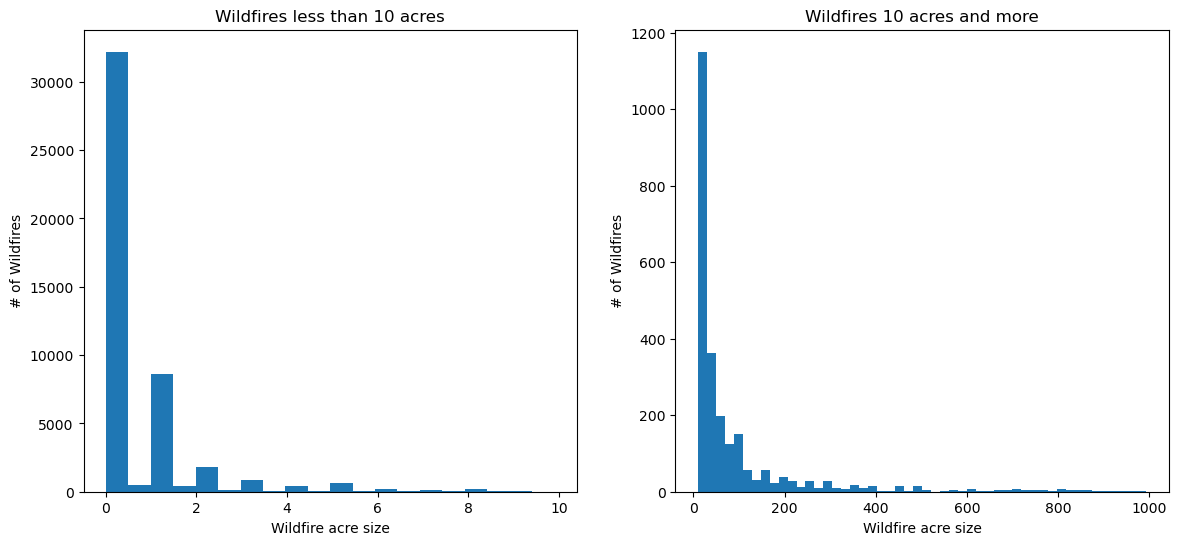

In [4]:
# most fires are smaller tah 5 acres (would be pretty bad otherwise)
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.hist(df[df.fire_size<10].fire_size,bins=20)
plt.title('Wildfires less than 10 acres')
plt.ylabel('# of Wildfires')
plt.xlabel('Wildfire acre size')
plt.subplot(122)
plt.hist(df[df.fire_size>=10].fire_size,bins=50)
plt.title('Wildfires 10 acres and more')
plt.ylabel('# of Wildfires')
plt.xlabel('Wildfire acre size')
plt.show()

In [5]:
# split data
train, val, test = w.split_data(df)
train.shape

(29415, 35)

Spearman's R: wind_direction_mean and fire_size
 r = 0.035106246474513485, p = 1.716338961742877e-09


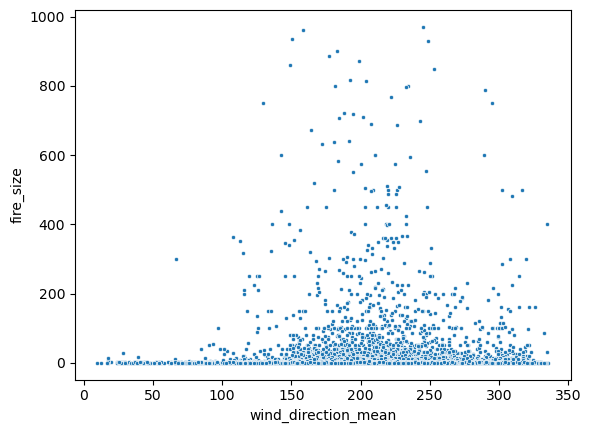

In [6]:
# wind_dir
e.pear(train, 'wind_direction_mean', 'fire_size')
sns.scatterplot(data=train,x='wind_direction_mean',y='fire_size',marker='.')
plt.show()

Spearman's R: time and fire_size
 r = -0.022553563086345926, p = 0.00010953185254689951


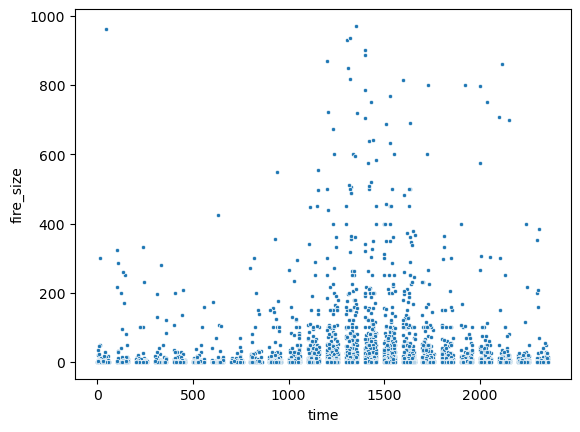

In [7]:
# time
e.pear(train, 'time', 'fire_size')
sns.scatterplot(data=train,x='time',y='fire_size',marker='.')
plt.show()

Spearman's R: humidity_mean and fire_size
 r = -0.02058084267886851, p = 0.0004155543747899636


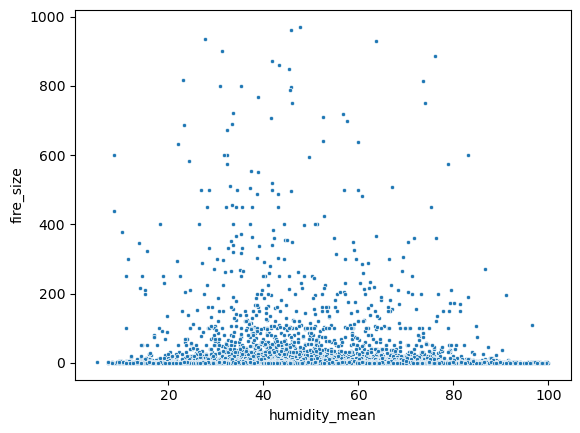

In [8]:
# humidity
e.pear(train, 'humidity_mean', 'fire_size')
sns.scatterplot(data=train,x='humidity_mean',y='fire_size',marker='.')
plt.show()

Spearman's R: temp_mean and fire_size
 r = 0.08005528978118515, p = 4.98052207682677e-43


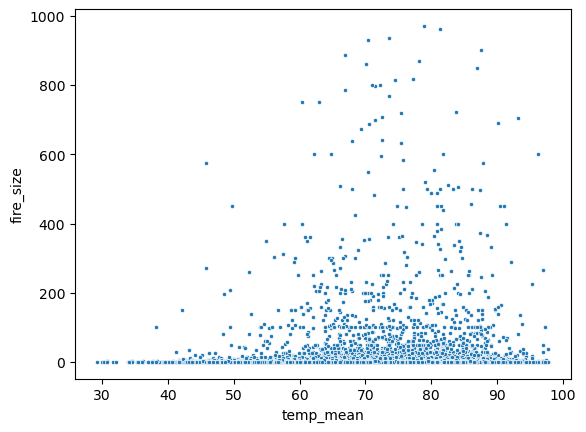

In [9]:
# temp
e.pear(train, 'temp_mean', 'fire_size')
sns.scatterplot(data=train,x='temp_mean',y='fire_size',marker='.')
plt.show()

Spearman's R: percent_trees_alive and fire_size
 r = 0.025799388288752487, p = 9.628585163532279e-06


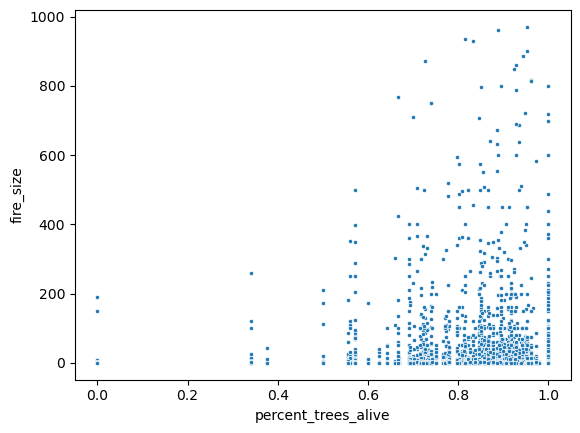

In [10]:
# alive
e.pear(train, 'percent_trees_alive', 'fire_size')
sns.scatterplot(data=train,x='percent_trees_alive',y='fire_size',marker='.')
plt.show()

In [11]:
# split into X and y
X_train = train.drop(columns=['fire_size','fire_size_class','date']).select_dtypes(exclude='object')
X_val = val.drop(columns=['fire_size','fire_size_class','date']).select_dtypes(exclude='object')
X_test = test.drop(columns=['fire_size','fire_size_class','date']).select_dtypes(exclude='object')
y_train,y_val,y_test = train[['fire_size']],val[['fire_size']],test[['fire_size']]

# Standard Scaler
Xs_train,Xs_val,Xs_test = w.std(X_train,X_val,X_test)

In [12]:
Xs_train.columns

Index(['time_s', 'lat_s', 'long_s', 'elevation_mean_s',
       'trees_per_acre_mean_s', 'percent_chance_water_nearby_s',
       'height_mean_s', 'diameter_mean_s', 'percent_trees_alive_s',
       'percent_invasive_plant_s', 'co_mean_s', 'temp_mean_s',
       'humidity_mean_s', 'wind_direction_mean_s', 'wind_speed_mean_s',
       'month_s', 'day_of_year_s', 'most_common_is_hardwood_s',
       'cause_class_human_s', 'cause_class_natural_s',
       'cause_class_undetermined_s', 'six_cali_central_cali_s',
       'six_cali_jefferson_s', 'six_cali_north_cali_s',
       'six_cali_silicon_valley_s', 'six_cali_south_cali_s',
       'six_cali_west_cali_s'],
      dtype='object')

In [13]:
# find best features
ranks_df = None
# feat = Xs_train.columns
feat = Xs_train.drop(columns=['cause_class_undetermined_s','cause_class_natural_s','cause_class_human_s',
                                'day_of_year_s','co_mean_s','six_cali_south_cali_s','six_cali_north_cali_s',
                                'six_cali_silicon_valley_s','six_cali_jefferson_s','six_cali_central_cali_s',
                                'six_cali_west_cali_s','time_s','wind_direction_mean_s','month_s','percent_chance_water_nearby_s',
                                'percent_trees_alive_s','height_mean_s','diameter_mean_s'
                                ]).columns
for r in range(1,len(feat)+1):
    dfr = m.rfe_rev(Xs_train[feat],y_train,r)
    dfr = dfr.assign(n_features=r)
    ranks_df = pd.concat([ranks_df,dfr]) if ranks_df is not None else dfr
rdf = pd.DataFrame(ranks_df.groupby(['Var']).Rank.mean().sort_values())
# ['lat_s','long_s','humidity_mean_s','wind_direction_mean_s','month_s','six_cali_west_cali_s','percent_invasive_plant_s','percent_trees_alive_s','height_mean_s','most_common_is_hardwood_s','wind_speed_mean_s','time_s']
print(len(rdf))
rdf

9


,Rank
Var,
temp_mean_s,1.000000
long_s,1.111111
lat_s,1.333333
humidity_mean_s,1.666667
wind_speed_mean_s,2.111111
most_common_is_hardwood_s,2.666667
trees_per_acre_mean_s,3.333333
percent_invasive_plant_s,4.111111
elevation_mean_s,5.000000


In [14]:
len(feat)

9

In [15]:
rm = m.reg_mods(Xs_train,y_train,Xs_val,y_val,features=feat)
rm

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
0,bl_mean,None,None,37.076012,45.150785,0.0000,-0.000184
1,LinearRegression,[lat_s],None,37.070000,45.150000,0.0003,0.000000
2,LinearRegression,[long_s],None,37.070000,45.140000,0.0003,0.000300
3,LinearRegression,[elevation_mean_s],None,37.080000,45.150000,0.0000,-0.000200
4,LinearRegression,[trees_per_acre_mean_s],None,37.080000,45.150000,0.0000,-0.000200
...,...,...,...,...,...,...,...
2040,TweedieRegressor,"[long_s, elevation_mean_s, trees_per_acre_mean...",power=2,37.030000,45.100000,0.0022,0.001900
2041,LinearRegression,"[lat_s, long_s, elevation_mean_s, trees_per_ac...",None,37.020000,45.070000,0.0030,0.003500
2042,LassoLars,"[lat_s, long_s, elevation_mean_s, trees_per_ac...",None,37.060000,45.140000,0.0007,0.000300
2043,PolynomialFeature,"[lat_s, long_s, elevation_mean_s, trees_per_ac...",None,36.970000,45.040000,0.0058,0.004800
